In [70]:
#imports
import pandas as pd
import spotipy
import spotipy.util as util
import json
import math
import types
from datetime import datetime
import csv
from dateutil.parser import parse
import requests
from bs4 import BeautifulSoup
import csv
import re
from unidecode import unidecode
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter

In [71]:
#appending the csvs I created in the initial gathering together
playlists1 = pd.read_csv('../data/raw/playlists.csv')
playlists2 = pd.read_csv('../data/raw/playlists2.csv')
playlists3 = pd.read_csv('../data/raw/playlists3.csv')

playlists_read = playlists1.append(playlists2)
playlists_read = playlists_read.append(playlists3)

# deduplicate the list on the spotify id -- again losing data at this point isn't a huge deal
# as this is about getting a variety of playlists for analysis, but none are required to make
# the tool better

dedup_playlists = playlists_read.drop_duplicates(subset='spotify_id')

In [72]:
# authorization for spotify
token = util.prompt_for_user_token(
        username="rosey.waters@gmail.com",
        scope="user-read-recently-played user-read-private user-top-read user-read-currently-playing",
        client_id="e7b1f1096c82471d89d1db8030b82dd9",
        client_secret="5e635c87338b4729bc9a8bd007c2cbe1",
        redirect_uri="https://www.google.it/")

spotify = spotipy.Spotify(auth=token)

In [73]:
# function that gets the track listing for songs from a playlist id, this will be useful later!

def total_track_listing(spotify_id, playlist_name):
    # create the url from the spotify id and the offset
    def create_url(spotify_id, offset):
        playlist = 'https://api.spotify.com/v1/playlists/' + spotify_id + '/tracks?offset=' + str(offset)
        return playlist

    # get the json information
    def get_json(playlist):
        try:
            def track_listing(self, limit=100):
                return self._get(playlist, limit=limit)

            spotify.track_listing = types.MethodType(track_listing, spotify)

            trackers = spotify.track_listing(limit=100)

            data = json.dumps(trackers, sort_keys=True, indent=2)

            data_parse = json.loads(data)

            return data_parse
        except:
            return ""
    
    def get_tracks(json):
        # create an empty list to add the information into
        created_list = []
        data = json["items"]
        for i in data:
        
            try:
                track_name = i["track"]["name"]
                primary_artist = i["track"]["artists"][0]["name"]
                artist_list = []
                for artist in i["track"]["artists"]:
                    artist_list.append(artist["name"])
                track_id = i["track"]["id"]
                info = [track_name, primary_artist, artist_list, track_id, playlist_name]
                created_list.append(info)
            except: 
                pass
            
        return created_list
    # this part cycles through the tracks if there are more than 100
    final = []
    offsetter = 0
    try:
        total = get_json(create_url(spotify_id,0))['total']

        while offsetter < total:
            run = get_json(create_url(spotify_id,offsetter))
            created = get_tracks(run)
            final += created
            offsetter += 100
    except:
        final += ["The playlist does not exist"]
    
    return final

In [74]:
spotid = '3agkpsN74bI0mtkWlnHlAR'
spotname = 'Sleepy'
print(spotid, spotname)

3agkpsN74bI0mtkWlnHlAR Sleepy


In [75]:
first = total_track_listing(spotid, spotname)
print(first)

[['Bed Bed Bed', 'They Might Be Giants (For Kids)', ['They Might Be Giants (For Kids)'], '5pRrxWjsp4zvTd2Zq2PtQL', 'Sleepy'], ['Sleep to Dream', 'Fiona Apple', ['Fiona Apple'], '51HiIbv8gO0HvwpmAxXAFe', 'Sleepy'], ['Awake', 'Tycho', ['Tycho'], '2qC1sUo8xxRRqYsaYEdDuZ', 'Sleepy'], ['Ramona - Acoustic Version', 'Beck', ['Beck'], '1Z50OHs5UJCybYStfwIcot', 'Sleepy'], ['We Used to Wait', 'Arcade Fire', ['Arcade Fire'], '37EmPMVwdBaKs7UhJOkHUU', 'Sleepy'], ['Cheerleader', 'St. Vincent', ['St. Vincent'], '2Eg8N0qgB1wQ64TexXSOCu', 'Sleepy'], ["Le tunnel d'or", 'AaRON', ['AaRON'], '6qZGHLpw8T2NFPSKj0dhTr', 'Sleepy'], ['Trouble Sleep Yanga Wake Am (with Merrill Garbus & Brittany Howard)', 'My Morning Jacket', ['My Morning Jacket', 'Brittany Howard', 'Merrill Garbus'], '5DHV4EeqkTKOzXla4wpnSJ', 'Sleepy'], ['Symphony 9 & the Sunshine', 'Emily Wells', ['Emily Wells'], '7cDI5QBBqCTXbCYbGFVuMy', 'Sleepy'], ['Deep As Love', 'Tord Gustavsen Trio', ['Tord Gustavsen Trio'], '5IF9fe5E8dAyODKoZj9Q99', 'Sle

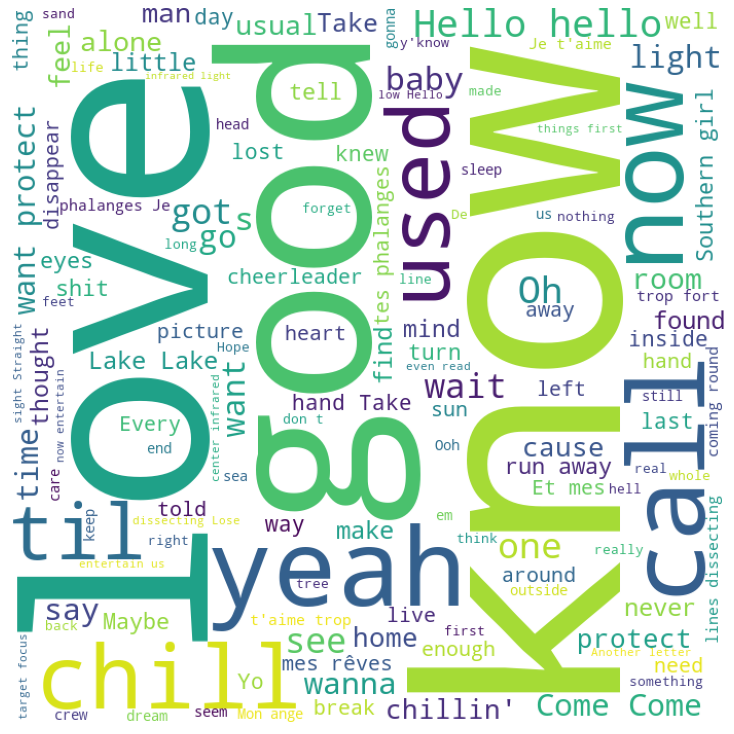

In [76]:
def genius_search(track_name, primary_artist, spotify_id, additional=''):

#artist processing
    
    # then adjusts non-latin characters
    # removes the spaces and turns them into dashes
    artist = primary_artist.replace("&","and")
    artist = unidecode(artist)
    artist = artist.replace("/","-")
    artist = re.sub("[^a-zA-z0-9 -]", "", artist)
    artist = artist.replace(" ","-")
    
#track processing
    # removes some of common features
    # then spaces and dashes
    track = track_name.replace("&","and")
    track = unidecode(track)
    track = track.replace("/","-")
    track = re.sub("[^a-zA-z0-9 -]", "", track)
    track = track.split('feat')[0]
    track = track.split('with')[0]
    track = track.strip().replace(" ","-")
    
    # creates the url
    url = "https://genius.com/" + artist + '-' + track + "-lyrics"
    
    # remove double dashes
    url = url.replace("--","-")
    singles = url.split('--')
    
    # sometimes there are remasters or singles
    # and this checks for them and fixes the url
    if len(singles) > 1:
        url = singles[0] + '-lyrics'
    
    #this is the first, basic try to get the lyrics off the url. 
    try: 
        response = requests.get(url)
        html = response.text
        soup = BeautifulSoup(html, "html.parser")

        lyrics = soup.findAll('div', attrs={'class': 'lyrics'})
        text = lyrics[0].p.get_text()
        tester = text
        
    # if this one doesn't work, then we go down to a different url
    except:
        # first to test to see if adding additional artists will help the url problem
        if len(additional) > 1:
            other = 1
            while other < len(additional):
                second = re.sub("[^a-zA-z0-9 -]", "", additional[other])
                second = second.replace(" ","-")
                new = '-and-' + second
                other += 1
            url = "https://genius.com/" + artist + '-and-' + second + '-' + track + "-lyrics"
        
            try:
                response = requests.get(url)
                html = response.text
                soup = BeautifulSoup(html, "html.parser")

                lyrics = soup.findAll('div', attrs={'class': 'lyrics'})
                text = lyrics[0].p.get_text()
                tester = text
                
            #if that doesn't work, then there's possibily something going on with the encoding
            except:
                try:
                    # so back to the original track name and artist. ø seems to really cause problems
                    # for genius urls, so this is what caught this part of the code
                    track = track_name.replace("&","and")
                    track = re.sub("[^a-zA-z0-9 -]", "", track)
                    track = track.split('feat')[0]
                    track = track.split('with')[0]
                    track = track.strip().replace(" ","-")
                    artist = primary_artist.replace("&","and")
                    artist = re.sub("[^a-zA-z0-9 -]", "", artist)
                    artist = artist.replace(" ","-")
                    url = "https://genius.com/" + artist + '-' + track + "-lyrics"
                    
                    response = requests.get(url)
                    html = response.text
                    soup = BeautifulSoup(html, "html.parser")

                    lyrics = soup.findAll('div', attrs={'class': 'lyrics'})
                    text = lyrics[0].p.get_text()
                    tester = text
                
                # if at this point there's just nothing, then while the song might exist on genius
                # the effort to find it is greater than the amount of coding work needed at this
                # stage. If I find something significant, then I'll come back and add into this
                except:
                    tester = ''
        else:
            tester = ''
    
    return tester

item = 0
lyric_blob = ''
while item < len(first):
    name = first[item][0]
    art = first[item][1]
    add = first[item][2]
    sid = first[item][3]
    lyric_search = genius_search(name, art, sid, add)
    lyric_blob += lyric_search
    item += 1
    
# removes anything between square brackets, which seems to be genius's way of
# doing things like "chorus" etc
gen = re.sub("([\[]).*?([\]])", "", lyric_blob)

# build a word cloud -- just to see if there's something else that should obviously be taken out
wordcloud = WordCloud(width = 700, height = 700, 
                background_color ='white', 
                min_font_size = 10).generate(gen) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()